# 3. Colours and Dust Extinction

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from mclearn.preprocessing import balanced_train_test_split
from mclearn.performance import (get_beta_parameters,
                                   beta_avg_inv_cdf)
from mclearn.viz import (plot_hex_map,
                         plot_balanced_accuracy_violin)
from mclearn.photometry import (reddening_correction_sfd98,
                                reddening_correction_sf11,
                                reddening_correction_w14,
                                correct_magnitudes,
                                compute_colours,
                                clean_up_subclasses)
from mclearn.classifier import train_classifier
%matplotlib inline
plt.style.use('ggplot')

In [2]:
sdss = pd.read_csv("../data/sdss_dr7_photometry_source.csv.gz", compression="gzip")
fig_dir = '../thesis/figures/'
target_col = 'class'

## Colour Indices

We use randomised logistic regression to examine the importance of various magnitudes and colour indices.

In [3]:
# compute possible PSF colour indices
sdss['psf_u_g'] = sdss['psfMag_u'] - sdss['psfMag_g']
sdss['psf_u_r'] = sdss['psfMag_u'] - sdss['psfMag_r']
sdss['psf_u_i'] = sdss['psfMag_u'] - sdss['psfMag_i']
sdss['psf_u_z'] = sdss['psfMag_u'] - sdss['psfMag_z']
sdss['psf_g_r'] = sdss['psfMag_g'] - sdss['psfMag_r']
sdss['psf_g_i'] = sdss['psfMag_g'] - sdss['psfMag_i']
sdss['psf_g_z'] = sdss['psfMag_g'] - sdss['psfMag_z']
sdss['psf_r_i'] = sdss['psfMag_r'] - sdss['psfMag_i']
sdss['psf_r_z'] = sdss['psfMag_r'] - sdss['psfMag_z']
sdss['psf_i_z'] = sdss['psfMag_i'] - sdss['psfMag_z']

# compute possible Petrosian colour indices
sdss['petro_u_g'] = sdss['petroMag_u'] - sdss['petroMag_g']
sdss['petro_u_r'] = sdss['petroMag_u'] - sdss['petroMag_r']
sdss['petro_u_i'] = sdss['petroMag_u'] - sdss['petroMag_i']
sdss['petro_u_z'] = sdss['petroMag_u'] - sdss['petroMag_z']
sdss['petro_g_r'] = sdss['petroMag_g'] - sdss['petroMag_r']
sdss['petro_g_i'] = sdss['petroMag_g'] - sdss['petroMag_i']
sdss['petro_g_z'] = sdss['petroMag_g'] - sdss['petroMag_z']
sdss['petro_r_i'] = sdss['petroMag_r'] - sdss['petroMag_i']
sdss['petro_r_z'] = sdss['petroMag_r'] - sdss['petroMag_z']
sdss['petro_i_z'] = sdss['petroMag_i'] - sdss['petroMag_z']

# collect together all candidnate features
all_features = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'psf_u_g',
                'psf_u_r', 'psf_u_i', 'psf_u_z', 'psf_g_r', 'psf_g_i', 'psf_g_z',
                'psf_r_i', 'psf_r_z', 'psf_i_z', 'petroMag_u', 'petroMag_g',
                'petroMag_r', 'petroMag_i', 'petroMag_z', 'petro_u_g', 'petro_u_r',
                'petro_u_i', 'petro_u_z', 'petro_g_r', 'petro_g_i', 'petro_g_z',
                'petro_r_i', 'petro_r_z', 'petro_i_z', 'petroRad_r']

In [ ]:
# split data into training and test sets
X_train, X_test, y_train, y_test = balanced_train_test_split(
        sdss, all_features, target_col, train_size=100000, test_size=200000, random_state=2)

# train a one-vs-rest randomised logistic regression
one = OneVsRestClassifier(
    RandomizedLogisticRegression(selection_threshold=0.5, n_jobs=-1, random_state=5))
one.fit(X_train, y_train)

# save the trained classifier
with open('../pickle/03_colours_and_dust_extinction/one.pickle', 'wb') as f:
    pickle.dump(one, f, pickle.HIGHEST_PROTOCOL)

In [7]:
with open('../pickle/03_colours_and_dust_extinction/one.pickle', 'rb') as f:
    one = pickle.load(f)

# display the scores of the features
scores = pd.DataFrame({'feature': all_features,
                       'score0': one.estimators_[0].scores_,
                       'score1': one.estimators_[1].scores_,
                       'score2': one.estimators_[2].scores_,})
scores['max_score'] = scores[['score0', 'score1', 'score2']].max(axis=1)
scores.sort('max_score', ascending=False)

,feature,score0,score1,score2,max_score
30,petroRad_r,0.960,0.915,1.000,1.000
14,psf_i_z,0.300,0.995,0.915,0.995
29,petro_i_z,0.660,0.955,0.540,0.955
3,psfMag_i,0.825,0.075,0.890,0.890
17,petroMag_r,0.880,0.755,0.795,0.880
5,psf_u_g,0.400,0.440,0.870,0.870
18,petroMag_i,0.870,0.785,0.800,0.870
1,psfMag_g,0.855,0.070,0.800,0.855
19,petroMag_z,0.830,0.550,0.850,0.850
4,psfMag_z,0.840,0.065,0.835,0.840


We will pick the 17 features with the highest scores. This includes all the original magnitude features plus 6 extra colour indices.

In [4]:
features = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'psf_u_g',
            'psf_g_r', 'psf_g_i', 'psf_r_i', 'psf_i_z', 'petroMag_u', 'petroMag_g',
            'petroMag_r', 'petroMag_i', 'petroMag_z', 'petro_i_z', 'petroRad_r']

## Dust Extinction

We examine the effect of applying three sets of reddening corrections to the measurements.

In [5]:
# compute the three sets of reddening correction
A_u_sfd98, A_g_sfd98, A_r_sfd98, A_i_sfd98, A_z_sfd98 \
    = reddening_correction_sfd98(sdss['extinction_r'])
A_u_sf11, A_g_sf11, A_r_sf11, A_i_sf11, A_z_sf11 \
    = reddening_correction_sf11(sdss['extinction_r'])
A_u_w14, A_g_w14, A_r_w14, A_i_w14, A_z_w14 \
    = reddening_correction_w14(sdss['extinction_r'])

# useful variables
psf_magnitudes = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']
petro_magnitudes = ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z']
sfd98_corrections = [A_u_sfd98, A_g_sfd98, A_r_sfd98, A_i_sfd98, A_z_sfd98]
sf11_corrections = [A_u_sf11, A_g_sf11, A_r_sf11, A_i_sf11, A_z_sf11]
w14_corrections = [A_u_w14, A_g_w14, A_r_w14, A_i_w14, A_z_w14]
colours = [('psfMag_u', 'psfMag_g'), ('psfMag_g', 'psfMag_r'), ('psfMag_g', 'psfMag_i'),
           ('psfMag_r', 'psfMag_i'), ('psfMag_i', 'psfMag_z'), ('petroMag_i', 'petroMag_z')]

# calculate the corrected magnitudes
correct_magnitudes(sdss, psf_magnitudes, sfd98_corrections, '_sfd98')
correct_magnitudes(sdss, petro_magnitudes, sfd98_corrections, '_sfd98')
correct_magnitudes(sdss, psf_magnitudes, sf11_corrections, '_sf11')
correct_magnitudes(sdss, petro_magnitudes, sf11_corrections, '_sf11')
correct_magnitudes(sdss, psf_magnitudes, w14_corrections, '_w14')
correct_magnitudes(sdss, petro_magnitudes, w14_corrections, '_w14')

# calculate the corrected magnitudes
compute_colours(sdss, colours, '')
compute_colours(sdss, colours, '_sfd98')
compute_colours(sdss, colours, '_sf11')
compute_colours(sdss, colours, '_w14')

In [10]:
(sdss['extinction_r'] / 2.751).describe()

count    2801002.000000
mean           0.043105
std            0.071149
min            0.002320
25%            0.019528
50%            0.030231
75%            0.048321
max           24.065954
Name: extinction_r, dtype: float64

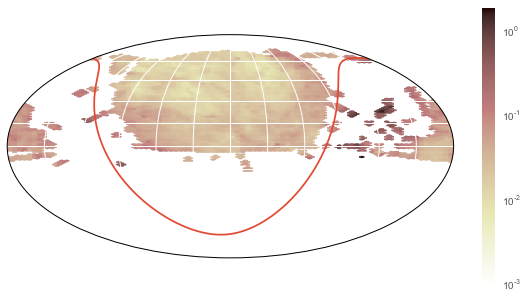

In [8]:
fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=sdss['extinction_r'] / 2.751, reduce_C_function=np.mean,
                  origin=180, vmin=0.001, vmax=2, mincnt=1, milky_way=True, norm=LogNorm(), cmap=plt.cm.pink_r)
fig.savefig(fig_dir + 'map_extinction_ebv.png', bbox_inches='tight', dpi=300)

Here are the extinction maps of the SF11 set in the ugriz bands (in that order).

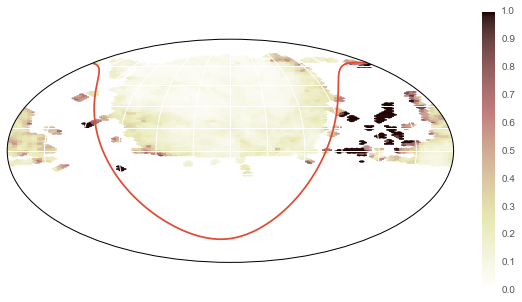

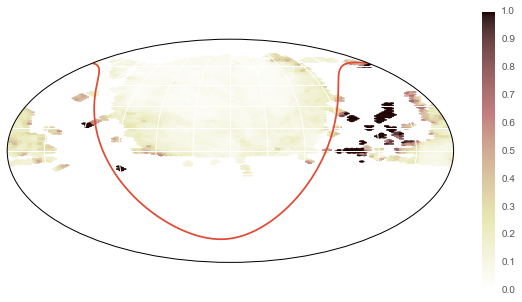

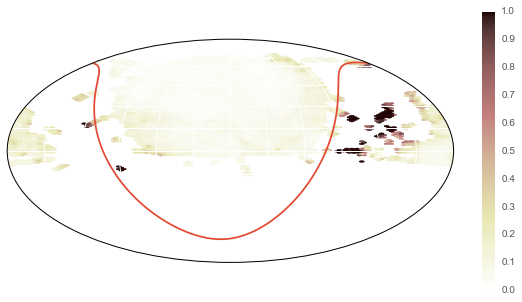

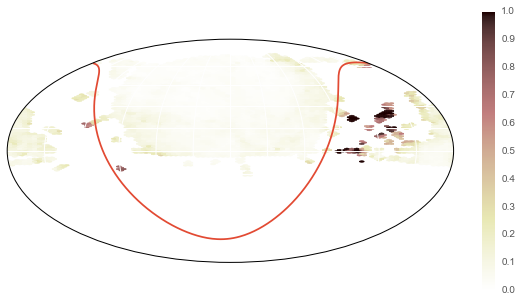

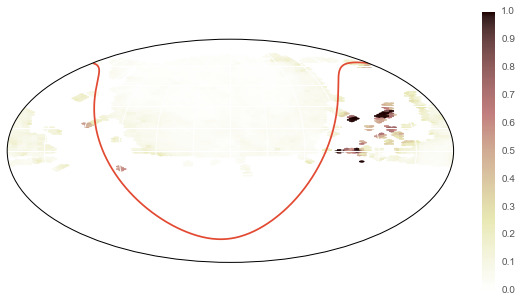

In [12]:
fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=A_u_sf11, reduce_C_function=np.mean,
                  origin=180, vmin=0, vmax=1, mincnt=1, milky_way=True, cmap=plt.cm.pink_r)
fig.savefig(fig_dir + 'map_extinction_sf11_u.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=A_g_sf11, reduce_C_function=np.mean,
                  origin=180, vmin=0, vmax=1, mincnt=1, milky_way=True, cmap=plt.cm.pink_r)
fig.savefig(fig_dir + 'map_extinction_sf11_g.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=A_r_sf11, reduce_C_function=np.mean,
                  origin=180, vmin=0, vmax=1, mincnt=1, milky_way=True, cmap=plt.cm.pink_r)
fig.savefig(fig_dir + 'map_extinction_sf11_r.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=A_i_sf11, reduce_C_function=np.mean,
                  origin=180, vmin=0, vmax=1, mincnt=1, milky_way=True, cmap=plt.cm.pink_r)
fig.savefig(fig_dir + 'map_extinction_sf11_i.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=A_z_sf11, reduce_C_function=np.mean,
                  origin=180, vmin=0, vmax=1, mincnt=1, milky_way=True, cmap=plt.cm.pink_r)
fig.savefig(fig_dir + 'map_extinction_sf11_z.png', bbox_inches='tight', dpi=300)

In [13]:
train_size = 100000
test_size = 200000

uncorrected_features = ['ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
                        'psfMag_z', 'psf_u_g', 'psf_g_r', 'psf_g_i', 'psf_r_i', 'psf_i_z',
                        'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
                        'petroMag_z', 'petro_i_z', 'petroRad_r']

sfd98_features = ['ra', 'dec', 'psfMag_u_sfd98', 'psfMag_g_sfd98', 'psfMag_r_sfd98',
                  'psfMag_i_sfd98', 'psf_u_g_sfd98', 'psf_g_r_sfd98', 'psf_g_i_sfd98',
                  'psf_r_i_sfd98', 'psf_i_z_sfd98', 'psfMag_z_sfd98', 'petroMag_u_sfd98',
                  'petroMag_g_sfd98', 'petroMag_r_sfd98', 'petroMag_i_sfd98',
                  'petroMag_z_sfd98', 'petro_i_z_sfd98', 'petroRad_r']

sf11_features = ['ra', 'dec', 'psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11',
                 'psfMag_i_sf11', 'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11',
                 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11', 'petroMag_u_sf11',
                 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                 'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

w14_features = ['ra', 'dec', 'psfMag_u_w14', 'psfMag_g_w14', 'psfMag_r_w14',
                'psfMag_i_w14', 'psfMag_z_w14', 'psf_u_g_w14', 'psf_g_r_w14',
                'psf_g_i_w14', 'psf_r_i_w14', 'psf_i_z_w14', 'petroMag_u_w14',
                'petroMag_g_w14', 'petroMag_r_w14', 'petroMag_i_w14',
                'petroMag_z_w14', 'petro_i_z_w14', 'petroRad_r']

Let's see how each set of correction performs. We start with the baseline (no correction). Then we look at the SFD98, the SF11, and finally the W14 set.

Here's the confusion matrix:


Predicted                
                 Galaxy  Quasar    Star
Actual Galaxy    195038    3848    1114
       Quasar      5492  185808    8700
       Star        2745   18215  179040

The balanced accuracy rate is 93.31%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9595    0.9752    0.9673    200000
       Star     0.9480    0.8952    0.9209    200000
     Quasar     0.8939    0.9290    0.9111    200000

avg / total     0.9338    0.9331    0.9331    600000

Recall Maps of Galaxies, Stars, and Quasars, respectively:


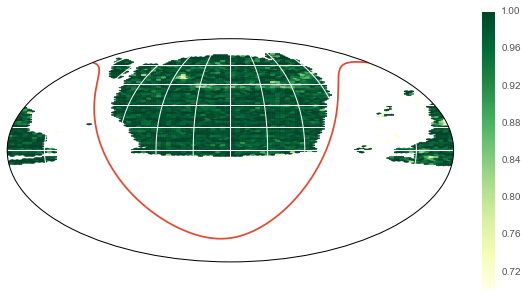

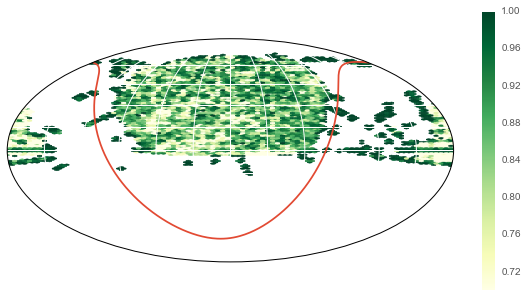

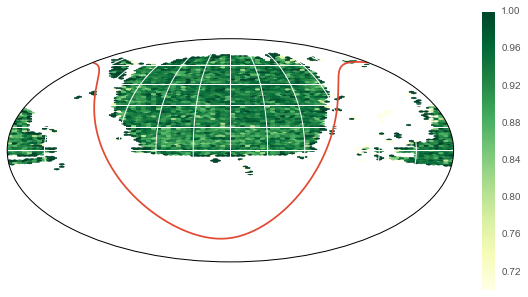

In [14]:
correct_baseline, confusion_baseline = train_classifier(sdss, uncorrected_features,
    target_col, train_size, test_size, 'uncorrected', random_state=2)

Here's the confusion matrix:


Predicted                
                 Galaxy  Quasar    Star
Actual Galaxy    194967    3944    1089
       Quasar      5485  185935    8580
       Star        2689   18443  178868

The balanced accuracy rate is 93.30%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9598    0.9748    0.9672    200000
       Star     0.9487    0.8943    0.9207    200000
     Quasar     0.8925    0.9297    0.9107    200000

avg / total     0.9337    0.9329    0.9329    600000

Recall Improvement Maps of Galaxies, Stars, and Quasars, respectively:


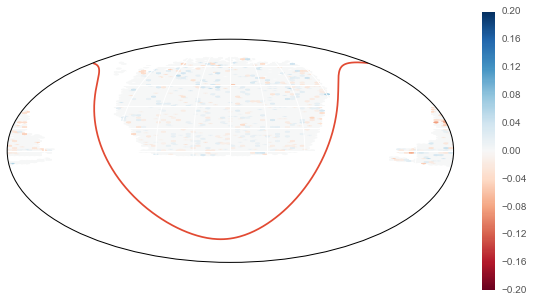

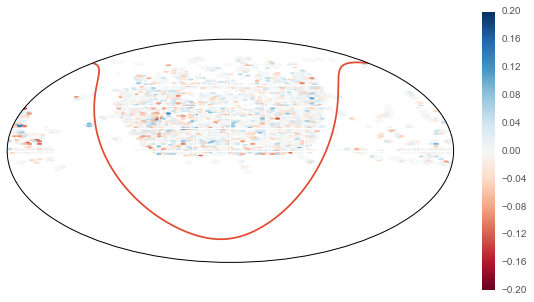

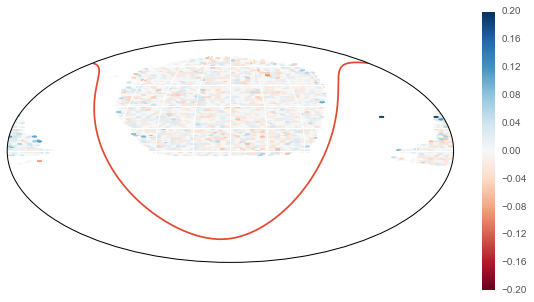

In [15]:
correct_sfd98, confusion_sfd98 = train_classifier(sdss, sfd98_features, target_col,
    train_size, test_size, 'sfd98', random_state=2, correct_baseline=correct_baseline)

Here's the confusion matrix:


Predicted                
                 Galaxy  Quasar    Star
Actual Galaxy    194973    3934    1093
       Quasar      5471  185975    8554
       Star        2684   18371  178945

The balanced accuracy rate is 93.32%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9599    0.9749    0.9673    200000
       Star     0.9488    0.8947    0.9210    200000
     Quasar     0.8929    0.9299    0.9110    200000

avg / total     0.9339    0.9332    0.9331    600000

Recall Improvement Maps of Galaxies, Stars, and Quasars, respectively:


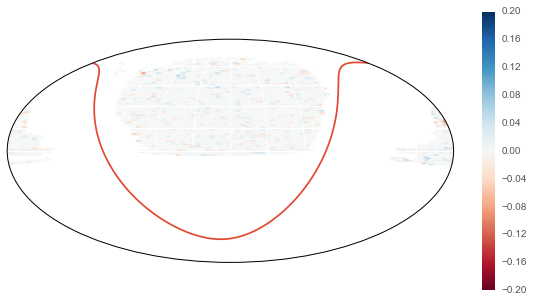

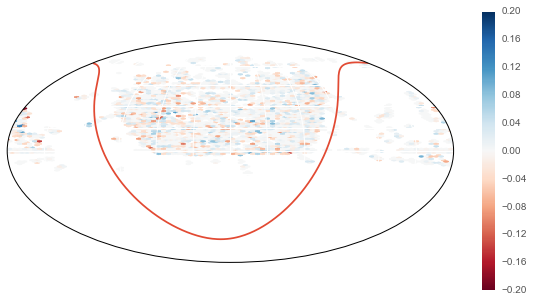

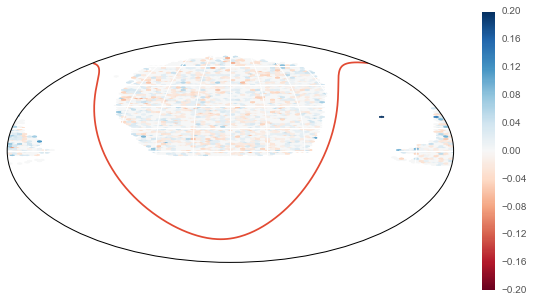

In [16]:
correct_sf11, confusion_sf11 = train_classifier(sdss, sf11_features, target_col,
    train_size, test_size, 'sf11', random_state=2, correct_baseline=correct_baseline)

Here's the confusion matrix:


Predicted                
                 Galaxy  Quasar    Star
Actual Galaxy    194932    3952    1116
       Quasar      5477  185885    8638
       Star        2692   18340  178968

The balanced accuracy rate is 93.30%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9598    0.9747    0.9672    200000
       Star     0.9483    0.8948    0.9208    200000
     Quasar     0.8929    0.9294    0.9108    200000

avg / total     0.9337    0.9330    0.9329    600000

Recall Improvement Maps of Galaxies, Stars, and Quasars, respectively:


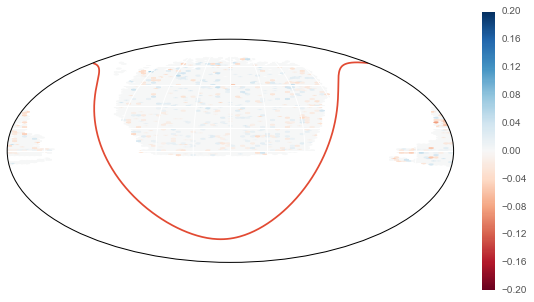

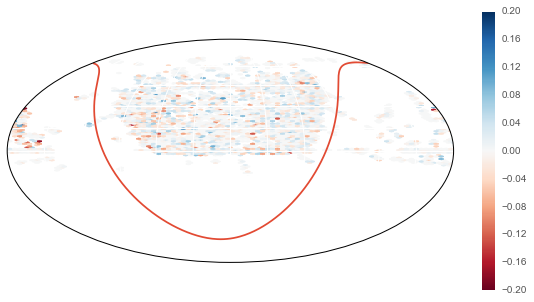

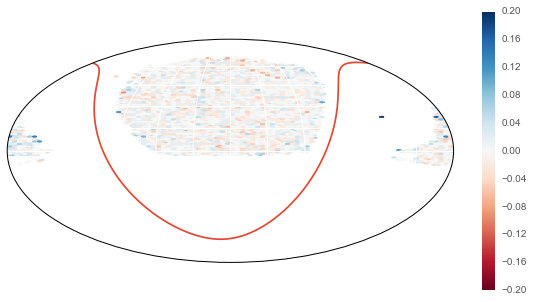

In [17]:
correct_w14, confusion_w14 = mclearn.train_classifier(sdss, w14_features, target_col,
    train_size, test_size, 'w14', random_state=2, correct_baseline=correct_baseline)

It might be easier to compare the results using violin plots.

In [18]:
confusions = [confusion_baseline, confusion_sfd98, confusion_sf11, confusion_w14]
balanced_accuracy_samples = []

rs = np.random.RandomState(17)
for confusion in confusions:
    parameters = get_beta_parameters(confusion)
    samples = [beta_avg_inv_cdf(rs.uniform(0, 1), parameters) for _ in range(100)]
    balanced_accuracy_samples.append(samples)

pickle_file = 'pickle/03_colours_and_dust_extinction/balanced_accuracy_samples.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(balanced_accuracy_samples, f, pickle.HIGHEST_PROTOCOL)

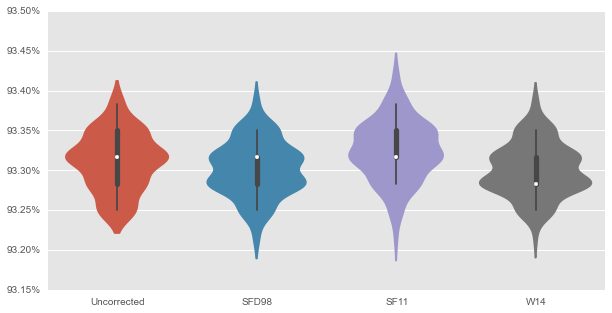

In [19]:
pickle_file = 'pickle/03_colours_and_dust_extinction/balanced_accuracy_samples.pickle'
with open(pickle_file, 'rb') as f:
    balanced_accuracy_samples = pickle.load(f)

fig = plt.figure(figsize=(10,5))
columns = ['Uncorrected', 'SFD98', 'SF11', 'W14']
accuracy_df = pd.DataFrame(balanced_accuracy_samples, index=columns).transpose()
plot_balanced_accuracy_violin(accuracy_df)
fig.savefig(fig_dir + 'violin_reddening_correction.pdf', bbox_inches='tight')

It seeems there is not much difference between the four correction sets. The SF11 set is perhaps slightly better, so we'll stick to SF11 from now on. Let's save the corrected features to an HDF5 table.

In [4]:
relevant_cols = ['ra', 'dec', 'class', 'psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11',
                 'psfMag_i_sf11', 'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11',
                 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11', 'petroMag_u_sf11',
                 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                 'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

sdss[relevant_cols].to_hdf('../data/sdss.h5', 'sdss')

Later on, we will explore subclasses, so let's save features with subclasses in a separate file.

In [ ]:
mclearn.clean_up_subclasses(sdss['class'], sdss['subclass'])
relevant_cols = ['ra', 'dec', 'subclass', 'psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11',
                 'psfMag_i_sf11', 'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11',
                 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11', 'petroMag_u_sf11',
                 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                 'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

sdss[sdss['subclass'] != ''][relevant_cols].to_hdf('data/sdss_subclass.h5', 'sdss_subclass')